In [164]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(palette='Set2')
import plotly.graph_objects as go
import random

import scipy.cluster.hierarchy as sch

from typing import Tuple

import warnings
warnings.filterwarnings('ignore')

import nbimporter

## Auxilary Functions

In [165]:
def get_ivp(cov: np.ndarray, **kargs) -> np.ndarray:
    '''
    Computes the inverse variance portfolio.
    
        Parameters:
            cov (np.ndarray): covariance matrix
            
        Returns:
            ivp (np.ndarray): optimal portfolio weights
    '''
    ivp = 1.0 / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

In [166]:
def get_cluster_var(cov: np.ndarray, cItems: np.ndarray) -> float:
    '''
    Computes variance per cluster
    
        Parameters:
            cov (np.ndarray): covariance matrix for all items
            cItems (np.ndarray): indexes of cluster items
            
        Returns:
            cVar (float): cluster variance
    '''
    cov_ = cov.loc[cItems, cItems]    # matrix slice
    w_ = get_ivp(cov_).reshape(-1, 1)
    cVar = np.dot(np.dot(w_.T, cov_), w_)[0, 0]
    return cVar

In [167]:
def get_quasi_diag(link: np.ndarray) -> list:
    '''
    Performs Quasi-Diagonalization by sorting clustered items by distance.
    
        Parameters:
            link (np.ndarray): a linkage matrix of size (N−1)x4
        
        Returns:
            lst (list): sorted items list
    '''
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]    # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)    # make space
        df0 = sortIx[sortIx >= numItems]    # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]    # item 1
        df0 = pd.Series(link[j, 1], index=i+1)
        sortIx = sortIx.append(df0)    # item 2
        sortIx = sortIx.sort_index()    # re-sort
        sortIx.index = range(sortIx.shape[0])    # re-index
    lst =  sortIx.tolist()
    return lst

In [168]:
def get_rec_bipart(cov: np.ndarray, sortIx: list) -> pd.Series:
    '''
    Computes Hierarchical Risk Parity allocation for a given subset of items.
    
        Parameters:
            cov (np.ndarray): covariance matrix
            sortIx (list): sorted items list
    '''
    w = pd.Series([1] * len(sortIx), index=sortIx)
    cItems = [sortIx]    # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[int(j): int(k)] for i in cItems
                  for j, k in ((0, len(i) / 2), (len(i) / 2, len(i))) if len(i) > 1]    # bi-section
        for i in range(0, len(cItems), 2):    # parse in pairs
            cItems0 = cItems[i]    # cluster 1
            cItems1 = cItems[i+1]    # cluster 2
            cVar0 = get_cluster_var(cov, cItems0)
            cVar1 = get_cluster_var(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha    # weight 1
            w[cItems1] *= 1 - alpha    # weight 2
    return w

In [169]:
def correl_dist(corr: np.ndarray) -> np.ndarray:
    '''
    Calculates a distance matrix based on correlation, where 0<=d[i,j]<=1. This is a proper distance metric.
    
        Parameters:
            corr (np.ndarray): correlation matrix
        
        Returns:
            dist (np.ndarray): distance matrix
    '''
    dist = ((1 - corr) / 2.0) ** 0.5    # distance matrix
    return dist

In [170]:
def plot_corr_matrix(corr: np.ndarray, labels: list = None, size: tuple = (9, 9)) -> None:
    '''
    Plots heatmap of the correlation matrix.
    
        Parameters:
            corr (np.ndarray): correlation matrix
            labels (list): labels for items
    '''
    fig, ax = plt.subplots(figsize=size)
    if labels is None:
        labels = []
    ax = sns.heatmap(corr)
    ax.set_yticks(np.arange(0.5, corr.shape[0] + 0.5), list(labels))
    ax.set_xticks(np.arange(0.5, corr.shape[0] + 0.5), list(labels))
    plt.show()

In [171]:
def generate_data(nObs: int, size0: int, size1: int, sigma1: float) -> Tuple[pd.DataFrame, list]:
    '''
    Generates data with correlations.
    
        Parameters:
            nObs (int): number of observations
            size0 (int): number of uncorrelated items
            size1 (int): number of correlated items
            sigma1 (float): std for random noise
            
        Returns:
            x (pd.DataFrame): dataframe with generated data
            cols (list): list with index of correlated items for each of the item in the list
    '''
    #1) generating some uncorrelated data
    np.random.seed(seed=42)
    random.seed(42)
    x = np.random.normal(0, 1, size=(nObs, size0))    # each row is a variable
    #2) creating correlation between the variables
    cols = [random.randint(0, size0 - 1) for i in range(size1)]
    y = x[:, cols] + np.random.normal(0, sigma1, size=(nObs, len(cols)))
    x = np.append(x, y, axis=1)
    x = pd.DataFrame(x, columns=range(1, x.shape[1] + 1))
    return x, cols

In [174]:
def run_simulation() -> None:
    '''
    Runs simulation and performs HRP algorithm.
    '''
    #1) Generate correlated data
    nObs, size0, size1, sigma1 = 10000, 5, 5, 0.25
    x, cols = generate_data(nObs, size0, size1, sigma1)
    print([(j + 1, size0 + i) for i, j in enumerate(cols, 1)])
    cov, corr = x.cov(), x.corr()
    #2) compute and plot correl matrix
    plot_corr_matrix(corr, labels=corr.columns, size=(8, 6.5))
    #3) cluster
    dist = correl_dist(corr)
    link = sch.linkage(dist, 'single')
    sortIx = get_quasi_diag(link)
    sortIx = corr.index[sortIx].tolist()    # recover labels
    df0 = corr.loc[sortIx, sortIx]    # reorder
    plot_corr_matrix(df0, labels=df0.columns, size=(8, 6.5))
    #4) Capital allocation
    hrp = get_rec_bipart(cov, sortIx)
    print(hrp)

Example:

[(1, 6), (1, 7), (3, 8), (2, 9), (2, 10)]


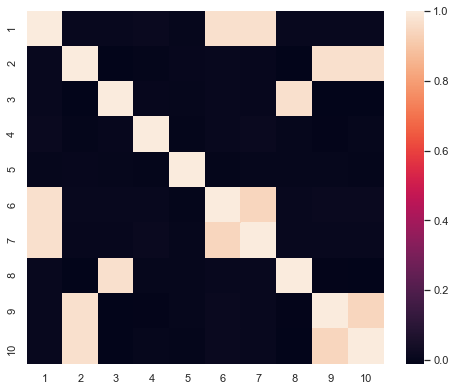

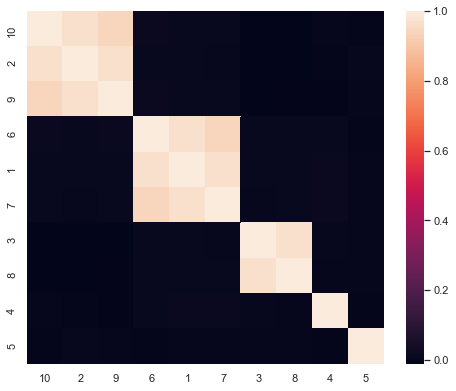

10    0.061731
2     0.065854
9     0.109618
6     0.053773
1     0.056898
7     0.122125
3     0.132012
8     0.124676
4     0.135965
5     0.137350
dtype: float64


In [175]:
run_simulation()

In [176]:
def generate_data_mc(
    nObs: int, sLength: int, size0: int, size1: int, mu0: float, sigma0: float, sigma1F: float
) -> Tuple[np.ndarray, list]:
    '''
    Generates data with two types of random shocks:
    common to various investments and specific to a single investment.
    
    Parameters:
            nObs (int): number of observations
            sLength (int): period length to compute HRP and IVP
            size0 (int): number of uncorrelated items
            size1 (int): number of correlated items
            mu0 (float): mean for generated uncorrelated data
            sigma0 (float): std for random noise
            sigma1F (float): multiplier for correlation noise
            
        Returns:
            x (np.ndarray): matrix with generated data
            cols (list): list with index of correlated items for each of the item in the list
    '''
    #1) generate random uncorrelated data
    x = np.random.normal(mu0, sigma0, size=(nObs, size0))
    #2) create correlation between the variables
    cols = [random.randint(0, size0 - 1) for i in range(size1)]
    y = x[:, cols] + np.random.normal(0, sigma0 * sigma1F, size=(nObs, len(cols)))
    x = np.append(x, y, axis=1)
    #3) add common random shock
    point = np.random.randint(sLength, nObs - 1, size=2)
    x[np.ix_(point, [cols[0], size0])] = np.array([[-0.5, -0.5], [2, 2]])
    #4) add specific random shock
    point = np.random.randint(sLength, nObs - 1, size=2)
    x[point, cols[-1]] = np.array([-0.5, 2])
    return x, cols

In [177]:
def get_hrp(cov: np.ndarray, corr: np.ndarray) -> pd.Series:
    '''
    Constructs a hierarchical portfolio.
    
        Parameters:
            cov (np.ndarray): covariance matrix
            corr (np.ndarray): correlation matrix
            
        Returns:
            hrp (pd.Series): portfolio weight given by HRP method
    '''
    corr, cov = pd.DataFrame(corr), pd.DataFrame(cov)
    dist = correl_dist(corr)
    link = sch.linkage(dist, 'single')
    sortIx = get_quasi_diag(link)
    sortIx = corr.index[sortIx].tolist()    # recover labels
    hrp = get_rec_bipart(cov,sortIx)
    return hrp.sort_index()

In [178]:
def hrp_mc(
    numIters: int = 1e2, nObs: int = 520, size0: int = 5, size1: int = 5, mu0: float = 0,
    sigma0: float = 1e-2, sigma1F: float = 0.25, sLength: int = 260, rebal: int = 22
) -> None:
    '''
    Performs Monte Carlo experiment on HRP method.
    
    Parameters:
        numIters (int): number of Monte Carlo iterations
        nObs (int): number of observations
        size0 (int): number of uncorrelated items
        size1 (int): number of correlated items
        mu0 (float): mean for generated uncorrelated data
        sigma0 (float): std for random noise
        sigma1F (float): multiplier for correlation noise
        sLength (int): period length to compute HRP and IVP
        rebal (int): rebalancing frequency (after how many periods we rebalance portfolios)
    '''
    methods = [get_ivp, get_hrp]
    stats, numIter = {i.__name__: pd.Series() for i in methods}, 0
    pointers = range(sLength, nObs, rebal)
    while numIter < numIters:
        #1) Prepare data for one experiment
        x, cols = generate_data_mc(nObs, sLength, size0, size1, mu0, sigma0, sigma1F)
        r = {i.__name__: pd.Series() for i in methods}
        #2) Compute portfolios in-sample
        for pointer in pointers:
            x_ = x[pointer - sLength: pointer]
            cov_, corr_ = np.cov(x_, rowvar=0), np.corrcoef(x_, rowvar=0)
            #3) Compute performance out-of-sample
            x_ = x[pointer: pointer + rebal]
            for func in methods:
                w_ = func(cov=cov_, corr=corr_)    # callback
                r_ = pd.Series(np.dot(x_, w_))
                r[func.__name__] = r[func.__name__].append(r_)
        #4) Evaluate and store results
        for func in methods:
            r_ = r[func.__name__].reset_index(drop=True)
            p_ = (1 + r_).cumprod()
            stats[func.__name__].loc[numIter] = p_.iloc[-1] - 1
        numIter += 1
    #5) Report results
    stats = pd.DataFrame.from_dict(stats, orient='columns')
    df0, df1 = stats.std(), stats.var()
    print(pd.concat([df0, df1, df1 / df1['get_hrp'] - 1], axis=1))

In [179]:
hrp_mc()

                0         1         2
get_ivp  0.303206  0.091934  0.333967
get_hrp  0.262522  0.068918  0.000000


## Exercises

### 1. PnL Series on N Investment Strategies.

Here I use data from `https://github.com/hudson-and-thames/mlfinlab/tree/master/mlfinlab/datasets`. First we have to derive weekly returns:

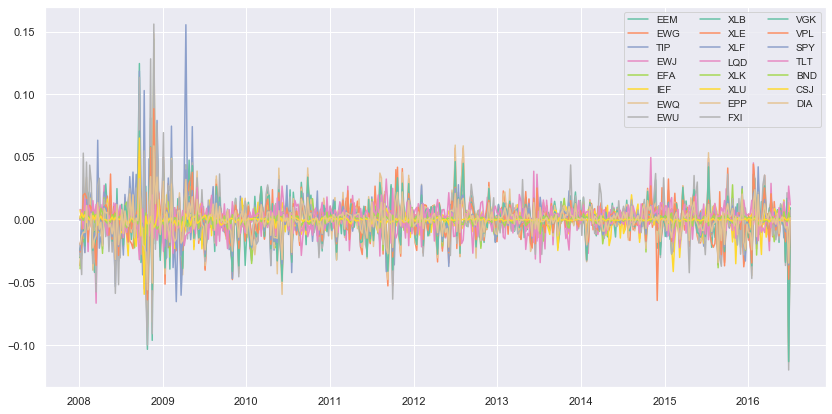

In [180]:
data = pd.read_csv('stock_prices.csv')
returns = data.drop('Date', axis=1).pct_change()[1:]
returns.index = pd.to_datetime(data['Date'][1:])
returns_weekly = returns.resample('W').last()

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(returns_weekly)
ax.legend(returns_weekly.columns, fontsize='small', ncol=3)
plt.show()

Now we compute the covariance of returns:

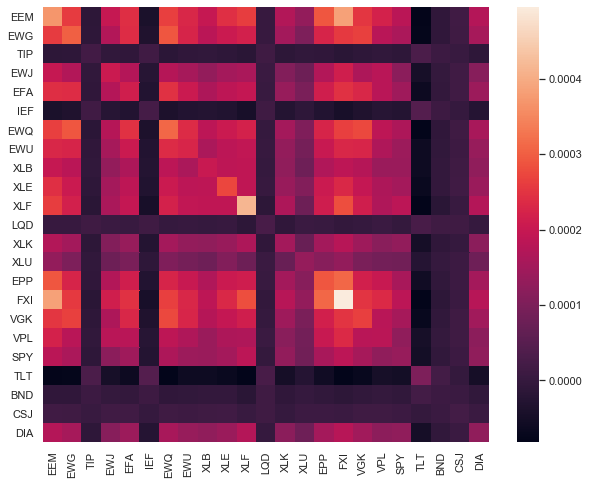

In [181]:
cov = returns_weekly.cov()
plot_corr_matrix(cov, list(returns_weekly.columns), size=(10, 8))

Hierarchical clusters:

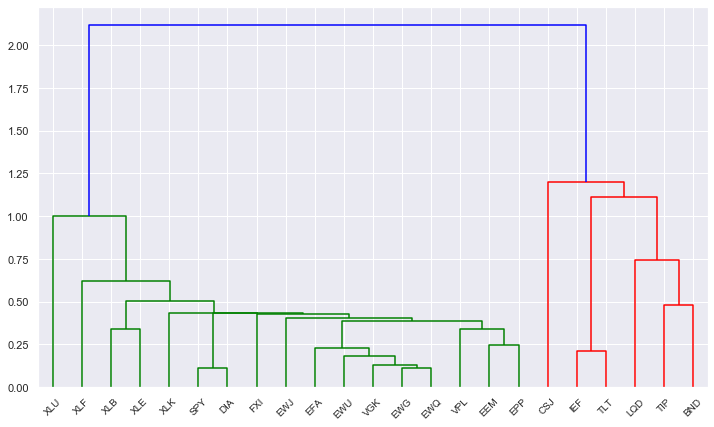

In [182]:
corr = returns_weekly.corr()
dist = correl_dist(corr)
link = sch.linkage(corr, 'single')
fig, ax = plt.subplots(figsize=(12, 7))
sch.dendrogram(link, ax=ax, labels=returns_weekly.columns)
plt.show()

Clustered correlation matrix:

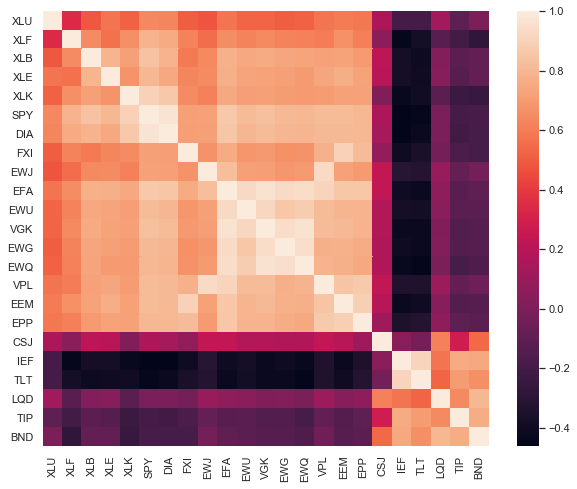

In [183]:
sortIx = get_quasi_diag(link)
sortIx = corr.index[sortIx].tolist()
df0 = corr.loc[sortIx, sortIx]
plot_corr_matrix(df0, labels=list(df0.columns), size=(10, 8))

### 2. HRP vs IVP.

HRP allocation:

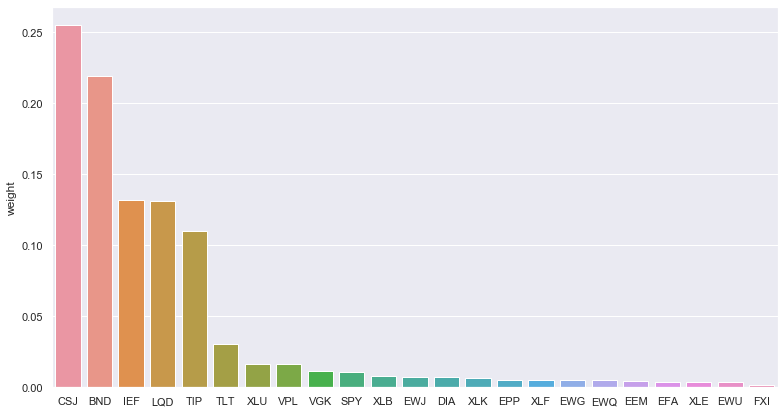

In [184]:
hrp = get_rec_bipart(cov, sortIx)
hrp_df = pd.DataFrame(hrp.sort_values(ascending=False), columns=['weight'])
fig, ax = plt.subplots(figsize=(13, 7))
ax = sns.barplot(x=hrp_df.index, y=hrp_df['weight'])
plt.show()

IVP allocation:

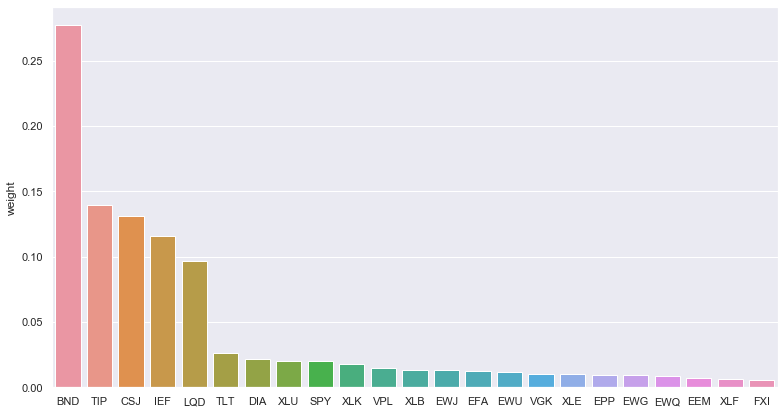

In [185]:
ivp = get_ivp(cov)
ivp_df = pd.DataFrame(data=sorted(ivp)[::-1], index=returns_weekly.columns[ivp.argsort()[::-1]], columns=['weight'])
fig, ax = plt.subplots(figsize=(13, 7))
ax = sns.barplot(x=ivp_df.index, y=ivp_df['weight'])
plt.show()